## Cargar datos


In [2]:
import os
import pandas as pd
from pathlib import Path
ruta_actual = Path.cwd()
PROJECT_DIR = ruta_actual.parents[1]
PROC_DIR     = PROJECT_DIR / 'data' / 'processed'

df=pd.read_csv(PROC_DIR/'dataset.csv')
df.head()

,Unnamed: 0,fecha,estacion,tsm,ano,mes,chla,mes_num,est_index,longitud,latitud,evento,oni
0,0,1981-09-01,est_1,30.5000,NaN,NaN,NaN,NaN,0.0,-109.3,23.8,Neutro,-0.2
1,1,1981-09-01,est_10,28.6250,NaN,NaN,NaN,NaN,9.0,-112.3,27.6,Neutro,-0.2
2,2,1981-09-01,est_11,29.1583,NaN,NaN,NaN,NaN,10.0,-112.6,28.0,Neutro,-0.2
3,3,1981-09-01,est_12,28.8750,NaN,NaN,NaN,NaN,11.0,-112.9,28.5,Neutro,-0.2
4,4,1981-09-01,est_13,26.9667,NaN,NaN,NaN,NaN,12.0,-113.2,28.9,Neutro,-0.2


In [5]:
df.dropna(inplace=True)
df.isna().sum()

Unnamed: 0    0
fecha         0
estacion      0
tsm           0
ano           0
mes           0
chla          0
mes_num       0
est_index     0
longitud      0
latitud       0
evento        0
oni           0
dtype: int64

In [8]:
df['fecha'] = pd.to_datetime(df['fecha'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4318 entries, 3264 to 7581
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  4318 non-null   int64         
 1   fecha       4318 non-null   datetime64[ns]
 2   estacion    4318 non-null   object        
 3   tsm         4318 non-null   float64       
 4   ano         4318 non-null   float64       
 5   mes         4318 non-null   object        
 6   chla        4318 non-null   float64       
 7   mes_num     4318 non-null   float64       
 8   est_index   4318 non-null   float64       
 9   longitud    4318 non-null   float64       
 10  latitud     4318 non-null   float64       
 11  evento      4318 non-null   object        
 12  oni         4318 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 472.3+ KB


In [17]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split

# --- Columnas --- #
category_columns=['ano','mes','mes_num','est_index']
numeric_columns=['oni','tsm','chla']
target_column='evento'

# Escalar datos númericos:
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[numeric_columns])
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_columns, index=df.index)

print( type(numeric_scaled) )

# Codificar columnas categóricas:
encoder = OneHotEncoder(sparse_output=False, drop='first') 
encoded_categories = encoder.fit_transform(df[category_columns])
encoded_category_columns = encoder.get_feature_names_out(category_columns)
encoded_categories_df = pd.DataFrame(encoded_categories, columns=encoded_category_columns, index=df.index)

print( type(encoded_categories) )

X = pd.concat([numeric_scaled_df, encoded_categories_df], axis=1)
y=df[target_column]




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Modelo

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)


/Users/federicocirett/Documents/GitHub/ae-oceanografia-golfo-cali/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

              precision    recall  f1-score   support

      Neutro       1.00      1.00      1.00       359
        Niña       1.00      1.00      1.00       284
        Niño       1.00      1.00      1.00       221

    accuracy                           1.00       864
   macro avg       1.00      1.00      1.00       864
weighted avg       1.00      1.00      1.00       864



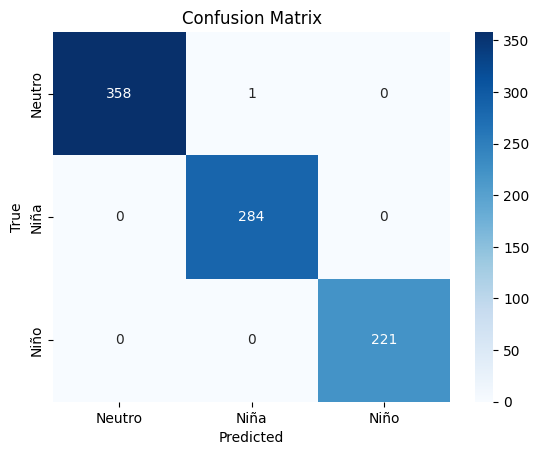

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluación
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
import joblib

os.makedirs(PROJECT_DIR/'models',exist_ok=True)

joblib.dump(model, PROJECT_DIR/'models'/'modelo_logistico.pkl')

['/Users/federicocirett/Documents/GitHub/ae-oceanografia-golfo-cali/models/modelo_logistico.pkl']

## Justificación